# **Objective**
#### This notebook focuses on utilizing a **Transformer model** for **image captioning** on a **small dataset**. **Image captioning** is a fascinating task that **combines computer vision** and **natural language processing** to **generate** meaningful **textual descriptions based on visual content**. The primary goal is to offer a **comprehensive resource** for individuals interested in **building** and **understanding** transformer models. It serves as a **step-by-step guide**, explaining the construction of a **transformer model** and the process of building it for **Image Captioning** tasks.

### What is a **Transformer** ?
> ##### A Transformer is a type of **deep learning model architecture** that is designed to **handle sequential data**, making it particularly **well-suited** for **Natural Language Processing (NLP)** tasks such as **machine translation**, and **text summarization**. Unlike **Recurrent Neural Networks (RNN)s** and **Long Short-Term Memory Networks (LSTMs)**, **transformers** allow for **parallelization** of training, making them **highly efficient** for both training and inference. **Notable transformer-based models** include **BERT** and **GPT**.
> ###### For **more information** please refer to **the paper** titled **"Attention is All You Need"** by **Vaswani et al.**, published in **2017**.

> ![Untitled.png](attachment:1e04accb-0d0d-4198-94cd-3f258b97b1db.png)

>##### **Input Embedding:** Captures **semantic relationships** between words by embedding them into a continuous vector space.
> ##### **Positional Encoding:** Provides information about the **positions** of words in a sequence. (**non-trainable**)
>##### **Multi-Head Attention:** Captures diverse aspects of the **relationships** between words by attending to different parts of the input sequence simultaneously.
>##### **Mask:** **Enables** the model to **disregard** both future tokens and padding tokens.
>##### **Multi-Head Cross-Attention:** This layer **is designed to attend to both** the input sequence and the output of the encoder. Attention mechanism, specifically the **cross-attention** layer, **is capable of handling inputs with varying lengths**.

## Methodology:
> #### 1. **Data and Pre-processing:**
> ##### The **Flickr30k** dataset is utilized, and pre-processing involves **caption normalization**, **length filtering**, and dataset splitting. **Image processing** functions, such as decoding, and **resizing**, are implemented. The dataset is prepared using **TensorFlow** functions, including shuffling, **mapping**, **batching**, and **prefetching for optimal parallelization**.
> #### 2. **Model Architecture:**
> ##### The model architecture comprises a pre-trained **EfficientNetB0 CNN** for **image feature extraction**. The extracted features undergo **normalization** and **dense** layers to **align dimensions** with the **encoder**. **The encoder** incorporates **multi-head attention** and **layer normalization**. **The decoder**, fed with **the target caption and encoder's output**, employs **positional embedding**, **masked multi-head attention**, **layer normalization**, **multi-head cross-attention**, **feed-forward layers**. **Ultimately** a **Dense layer** with **softmax** activation serves as **the output layer**.
> #### 3. **Training:**
> ##### **The model** will be trained using the **images** as inputs **for encoder** and **their corresponding 5 captions[:, :-1]** (excluding the <end\> token) as inputs **for decoder**. **The target** captions will consist of **the corresponding five captions[:, 1:]** (excluding the <start\> token). The primary objective is to **update weights** and **minimize the loss** during training.
> #### 4. **Inference:**
> ##### **Sparse Categorical Crossentropy loss** is used for validation **during training**, while the **Greedy algorithm** combined with **BLEU score** evaluation is employed for **generating captions** on **test set**.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hsankesara_flickr_image_dataset_path = kagglehub.dataset_download('hsankesara/flickr-image-dataset')

print('Data source import complete.')

Using Colab cache for faster access to the 'flickr-image-dataset' dataset.
Data source import complete.


In [ ]:
# BERTScore dependency (Optional)
# Run only if BERTScore appears as "unavailable".

!pip -q install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.6 MB/s eta 0:00:00


## Library setup

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from collections import Counter

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
from collections import Counter
import nltk
nltk.download('wordnet')

# By setting a random seed, we ensure that the sequence of random numbers generated during training,
                                                  # remains the same across different runs of the code.
# keras.utils.set_random_seed(111)

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Data and Pre-processing

In [ ]:
# Path to the images
IMAGES_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
# Path to the captions
CAPTIONS_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Fixed length allowed for any sequence
SEQ_LENGTH = 24

# Vocabulary size
VOCAB_SIZE = 13000

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Batch size
BATCH_SIZE = 64 # Reduced from 512 to 64 to alleviate GPU memory issues

# Number of epochs
EPOCHS = 30

In [ ]:
# Loads captions (text) data and maps them to corresponding images.
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()[1:]
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Each image is repeated five times for the five different captions.
            # Image name and captions are separated using a comma
            try:
                img_name, _, caption = line.split("| ")
                # There is one row in the dataset which causes ValueError when splitting.
                # Handling the error:
            except ValueError:
                img_name, caption = line.split("| ")
                caption = caption[4:]

            img_name = os.path.join(IMAGES_PATH, img_name.strip())
            # Removing caption that are either too short to too long
            tokens = caption.strip().split()
            if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # A start and an end token must be added to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data

# Splits the dataset into training, validation, and test sets
def train_val_split(caption_data, validation_size=0.2, test_size=0.02, shuffle=True):
    # Getting the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)

    training_data = {img_name: caption_data[img_name] for img_name in train_keys}
    validation_data = {img_name: caption_data[img_name] for img_name in validation_keys}
    test_data = {img_name: caption_data[img_name] for img_name in test_keys}

    # Return the splits
    return training_data, validation_data, test_data

# Loading the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Spliting the dataset
train_data, validation_data, test_data = train_val_split(captions_mapping)
print(f"Total number of samples: {len(captions_mapping)}")
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

Total number of samples: 26144
----> Number of training samples: 20915
----> Number of validation samples: 5124
----> Number of test samples: 105


## Defining **the vectorizer** with custom standardization and image augmentation

In [ ]:
def custom_standardization(input_string):
    # Lowercasing all of the captions
    lowercase = tf.strings.lower(input_string)
    # Charecters to remove
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~1234567890"
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Defining the vectorizer
vectorization = TextVectorization(
    # Number of unique tokens
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    # Maximum length of captions. Padding tokens(zeros) will be added to shorter captions.
    output_sequence_length=SEQ_LENGTH,
    # Standardizing the captions
    standardize=custom_standardization)

# Adapting the vectorizer with the captions
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                       layers.RandomRotation(0.2),
                                       layers.RandomContrast(0.3)])

# Standardizing the text data
text_data = list(map(lambda x: str(custom_standardization(x).numpy())[2:-1], text_data))

## Visualizing some of the images along with the corresponding captions

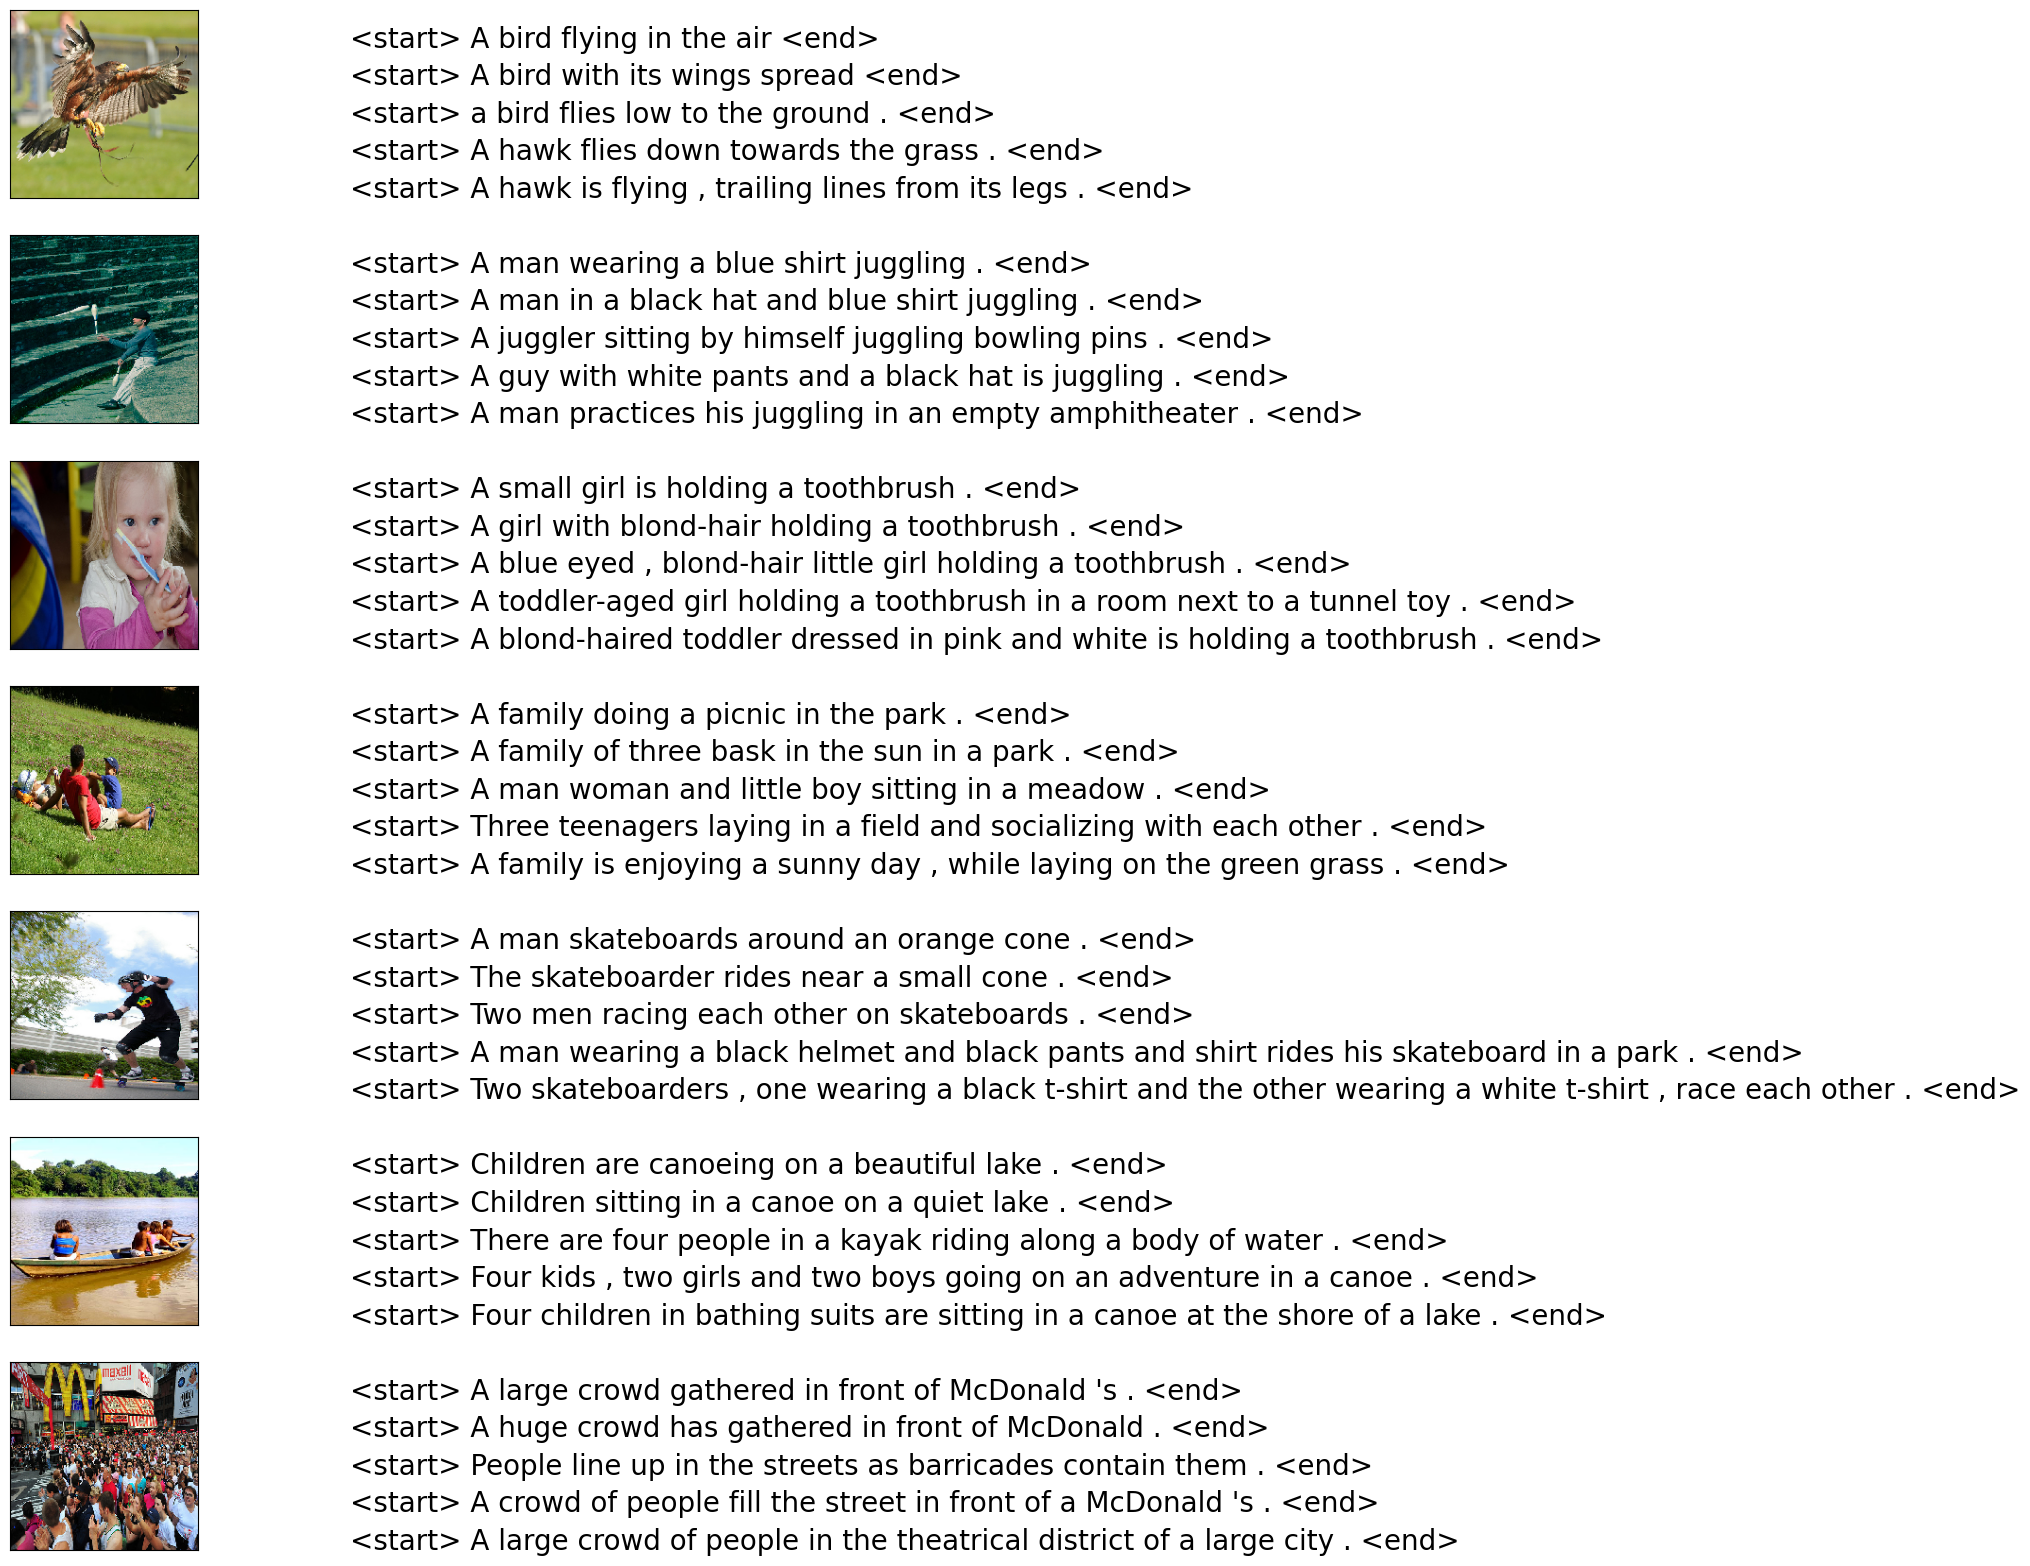

In [ ]:
def visualaization(data, num_of_images):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(data.keys())[100:100+num_of_images]:
        captions = data[filename]
        image_load = load_img(filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(train_data, 7)

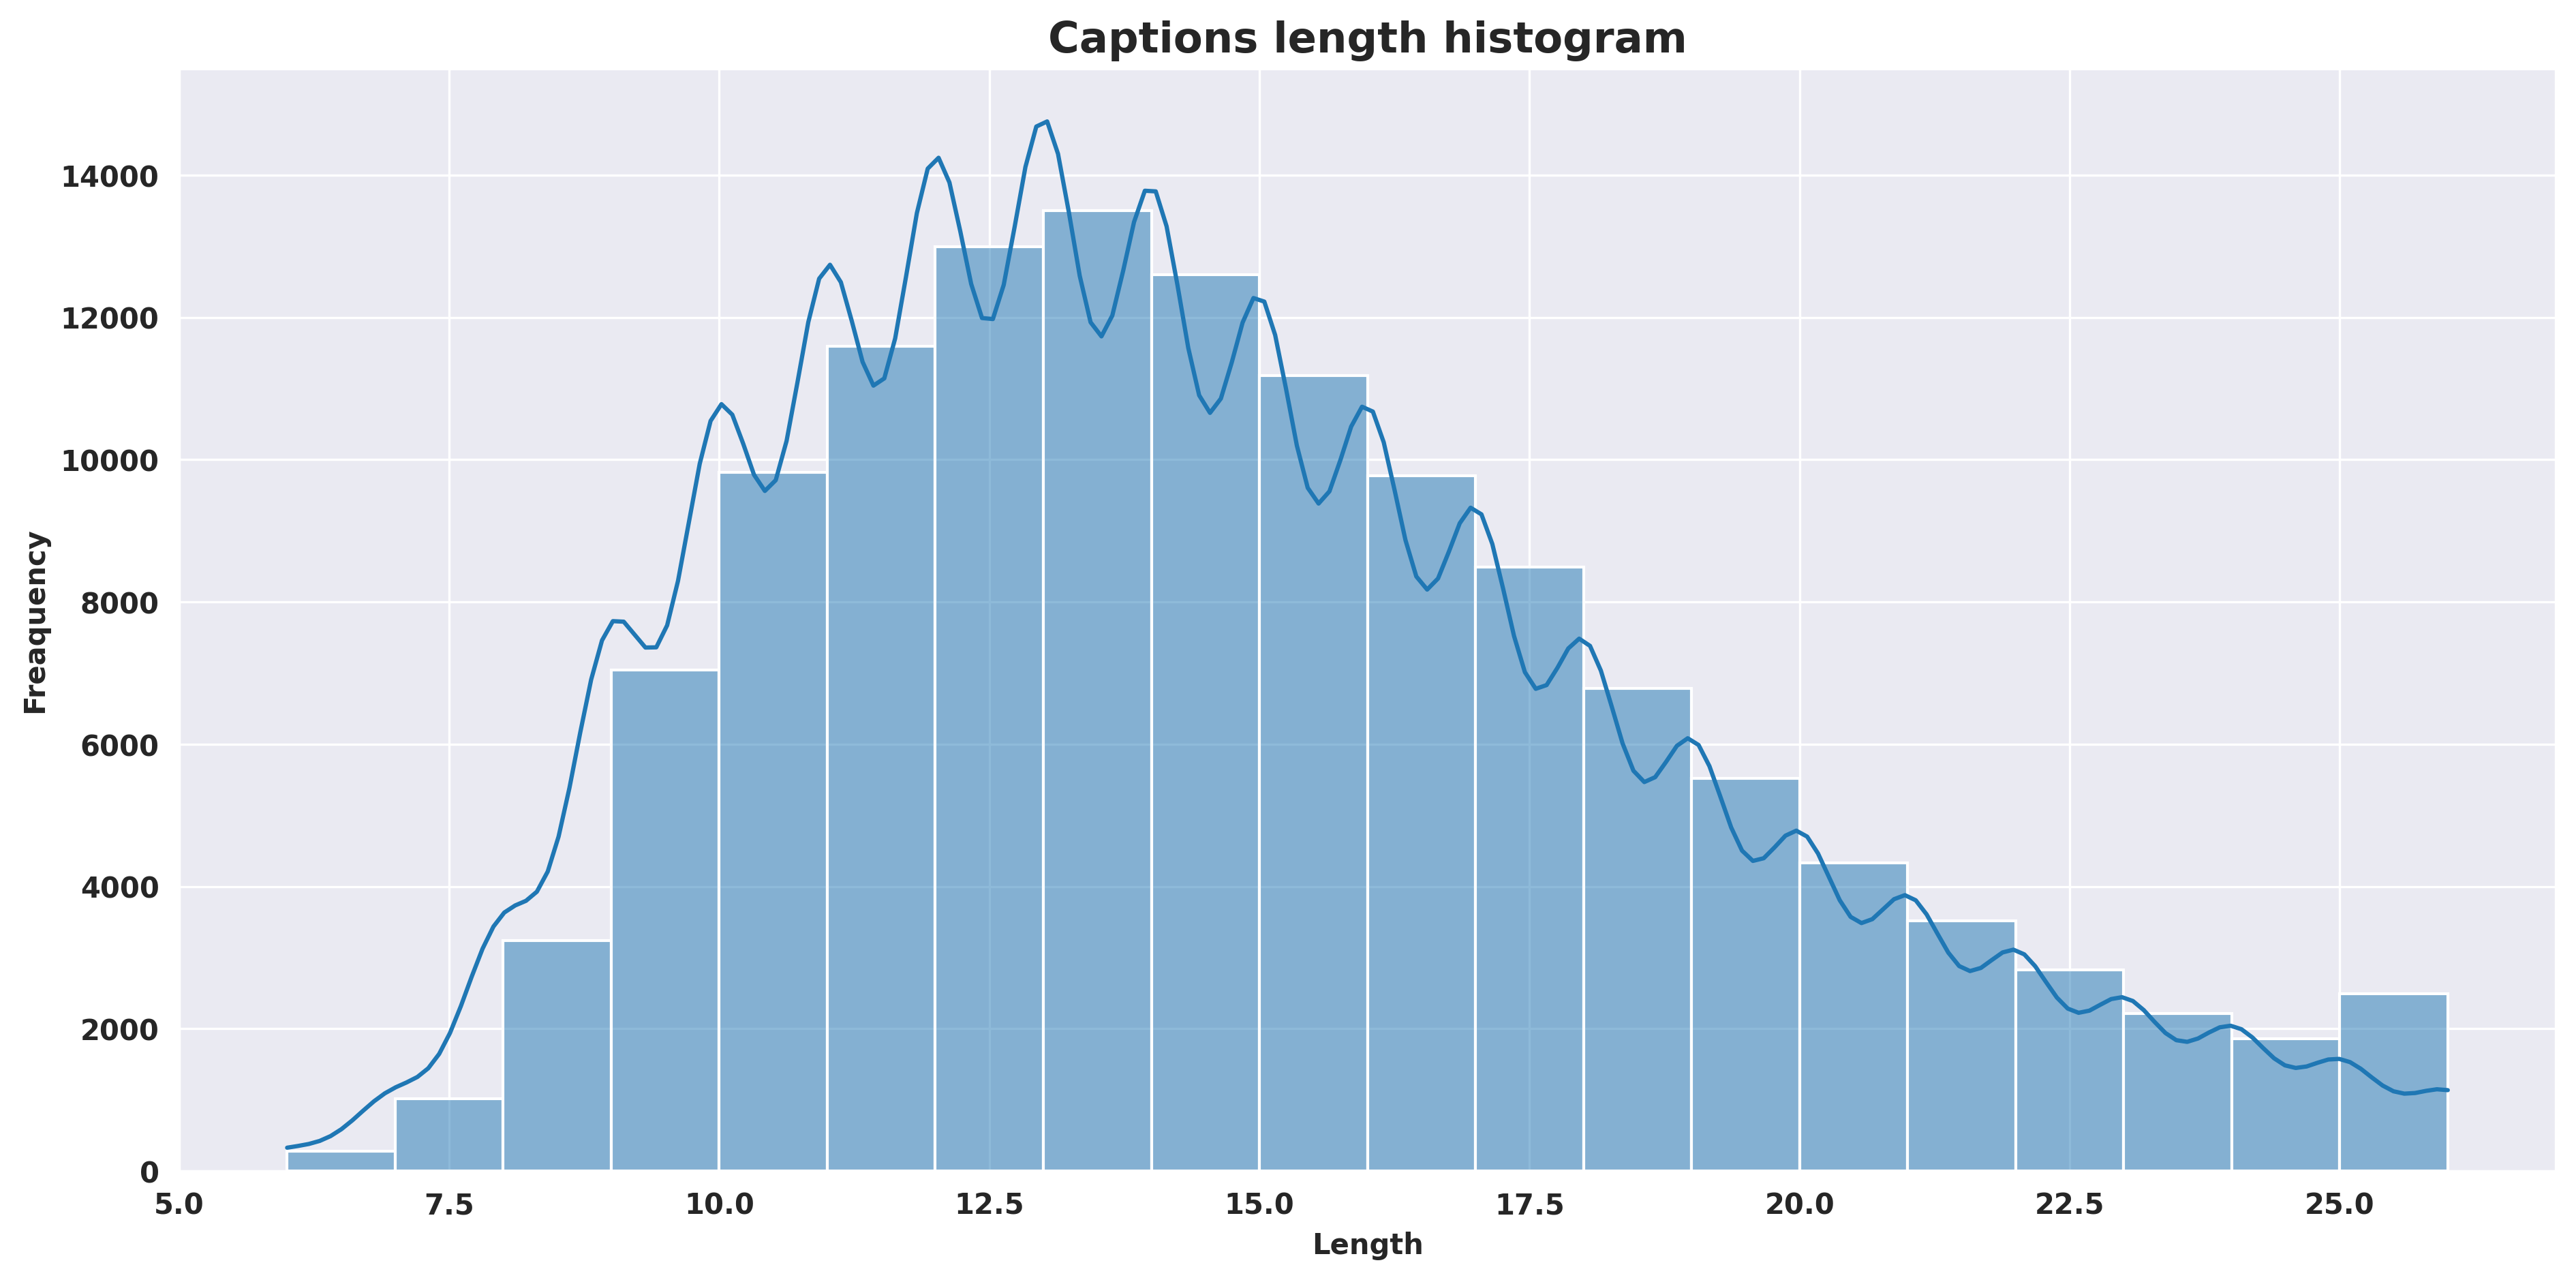

In [ ]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(text_data)

In [ ]:
def word_occurrences(data):
    # Combining all sentences into a single string
    all_text = ' '.join(data)
    all_text = all_text.replace('a ', '')
    all_text = all_text.replace('<start> ', '')
    all_text = all_text.replace('<end> ', '')
    # Splitting the text into words and count occurrences
    word_counts = Counter(all_text.split())

    words = list(word_counts.keys())[:30]
    values = list(word_counts.values())[:30]

    # Normalize values to be between 0 and 1
    normalized_values = np.array(values) / np.max(values)
    colors = np.array(['rgba(30, 58, 138, {})'.format(0.4 + 0.5 * (value)) for value in normalized_values])

    fig = go.Figure(data=[go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label')])

    fig.update_layout(title_text='Word occurrences in captions (except for letter \'a\')', title_font=dict(size=23, family='Balto'))

    fig.show()

word_occurrences(text_data)

# **Data Setup for Model Input**
##### **Parallelization** Involves **breaking down a task** into **smaller subtasks** that can be **executed in parallel**.
##### **'tf.data.AUTOTUNE'** determines the **optimal** level of **parallelism**.

In [ ]:
# Processes the images
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    # Processed images: (None, 299, 299, 3), Vectorized captions: (None, None, 25)
    return decode_and_resize(img_path), vectorization(captions)

# Prepares the dataset
def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=tf.data.AUTOTUNE)
    # Prefetching the next batch of data based on available resources while the current batch is being processed.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset


# Making the datasets by passing the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
validation_dataset = make_dataset(list(validation_data.keys()), list(validation_data.values()))

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 24), dtype=tf.int64, name=None))>

# **Defining** the **Image Captioning** Model

> ### **CNN** (feature extraction)
> * Pre-Trained model: EfficientNetB0

> ### **Encoder** (embedded image features)
> * Layer Normalization Layer
> * Dense Layer
> * Multi-Head Attention Layer
> * Layer Normalization Layer

> ### **Decoder** (embedded captions)
> * Positional Embedding Layer (input embedding + positional encoding)
> * Mask (enables the model to ignore both padding tokens and future tokens)
> * Multi-Head Attention Layer
> * Layer Normalization Layer
> * Multi-Head Cross-Attention Layer
> * Layer Normalization Layer
> * Feed Forward Layer
> * Layer Normalization Layer

> ### **Output**
> * Dense Layer + Softmax activation function

In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False, # Removing the prediction layers
        weights="imagenet")
    # Freezing the model's weights
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.0)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=None,
                                              training=training)
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # Positional encoding
        embedded_tokens = self.token_embeddings(inputs) # Input embedding
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # Positional embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.cross_attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(embed_dim=EMBED_DIM,
                                             sequence_length=SEQ_LENGTH,
                                             vocab_size=VOCAB_SIZE,)
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        # If the mask is not None, it means that padding tokens are present in the input sequence.
        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            # Masking both padding tokens and future tokens
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=combined_mask,
                                              training=training)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Note that the lengths of the inputs are different and cross-attention handles that.
        cross_attention_output_2 = self.cross_attention_2(query=out_1,
                                              value=encoder_outputs,
                                              key=encoder_outputs,
                                              attention_mask=padding_mask,
                                              training=training)
        out_2 = self.layernorm_2(out_1 + cross_attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)

        preds = self.out(ffn_out)
        return preds

    # Masks future tokens
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1),tf.constant([1, 1], dtype=tf.int32)],axis=0)
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

        print()
        print(f'CNN input shape: {cnn_model.input_shape}')
        print(f'CNN output shape: {cnn_model.output_shape}', end='\n'*2)
        print(f'Encoder input ---> Dense layer shape: {cnn_model.output_shape} ---> (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Encoder output shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})', end='\n'*2)
        print(f'Decoder input 1 (Caption) ---> Positional Embedding shape: (None, {SEQ_LENGTH-1}) ---> (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder input 2 (Embedded image features) shape: (None, {cnn_model.output_shape[1]}, {EMBED_DIM})')
        print(f'Decoder output (MH Cross-Attention) shape: (None, {SEQ_LENGTH-1}, {EMBED_DIM})')
        print(f'Decoder prediction (Dense layer) shape: (None, {SEQ_LENGTH-1}, {VOCAB_SIZE})')


    # Calculates the loss, taking into account a mask to handle padding.
    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    # Calculates the accuracy, taking into account a mask to handle padding.
    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        # Creating a binary mask where 1 indicates a valid token, and 0 indicates padding.
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    # Iterates through each caption for the given image, computes loss and accuracy, updates weights, and trackers.
    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # Applies image augmentation if image_aug is provided.
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=True)

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

    # Similar to train_step but without updating weights.
    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(img_embed, batch_seq[:, i, :], training=False)

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(),
                "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We must list the metrics here so the `reset_states()` can be,
                                                  # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=3)
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

CNN input shape: (None, 299, 299, 3)
CNN output shape: (None, 100, 1280)

Encoder input ---> Dense layer shape: (None, 100, 1280) ---> (None, 100, 512)
Encoder output shape: (None, 100, 512)

Decoder input 1 (Caption) ---> Positional Embedding shape: (None, 23) ---> (None, 23, 512)
Decoder input 2 (Embedded image features) shape: (None, 100, 512)
Decoder output (MH Cross-Attention) shape: (None, 23, 512)
Decoder prediction (Dense layer) shape: (None, 23, 13000)


# Training the model
##### **SparseCategoricalCrossentropy** is **commonly used** for tasks where **each target sequence is a sequence of integers** representing the **class indices**.


In [ ]:
# Defining the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

# EarlyStopping criteria
# Training will stop if there is no improvement in the validation loss for 3 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate)

# Creating a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compiling the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Training the model
history = caption_model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - acc: 0.1850 - loss: 31.8534 - val_acc: 0.3496 - val_loss: 18.5872
Epoch 2/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - acc: 0.3495 - loss: 18.3248 - val_acc: 0.3758 - val_loss: 16.8334
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - acc: 0.3743 - loss: 16.6983 - val_acc: 0.3914 - val_loss: 15.9743
Epoch 4/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - acc: 0.3887 - loss: 15.7972 - val_acc: 0.3992 - val_loss: 15.5535
Epoch 5/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - acc: 0.3990 - loss: 15.1695 - val_acc: 0.4053 - val_loss: 15.2976
Epoch 6/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - acc: 0.4077 - loss: 14.6993 - val_acc: 0.4089 - val_loss: 15.0913
Epoch 7/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - acc: 0.4141 - loss: 14.3135 - val_acc: 0.4112 - val_loss: 15.0096
Epoch 8/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - acc: 0.4212 - loss: 13.9701 - val_acc: 0.4138 - val_loss: 14.9025
Epoch 9/30
327/327 ━━━━━━━━━━━━━

In [ ]:
# Exporting the model (API)
# Save weights (includes EfficientNet + encoder + decoder) and TextVectorization artifacts.

import os
import json
import datetime

EXPORT_DIR = os.path.abspath(os.path.join("captioning-model", "v1"))
os.makedirs(EXPORT_DIR, exist_ok=True)

# 1) Pesos
weights_path = os.path.join(EXPORT_DIR, "caption_model.weights.h5")
caption_model.save_weights(weights_path)

# 2) Vocabulary of the vectorizer (token -> id mapping)
vocab = vectorization.get_vocabulary()
with open(os.path.join(EXPORT_DIR, "vocab.json"), "w", encoding="utf-8") as f:
    json.dump(vocab, f, ensure_ascii=False, indent=2)

# 3) Config of the vectorizer (no state; the state is the vocabulary above)
# Note: get_config() may contain functions (ex: custom_standardization) and is not serializable in JSON.
vectorizer_cfg = vectorization.get_config()
for key in ["standardize", "split"]:
    if callable(vectorizer_cfg.get(key)):
        vectorizer_cfg[key] = getattr(vectorizer_cfg[key], "__name__", str(vectorizer_cfg[key]))
with open(os.path.join(EXPORT_DIR, "vectorizer_config.json"), "w", encoding="utf-8") as f:
    json.dump(vectorizer_cfg, f, ensure_ascii=False, indent=2)

# 4) Model metadata (to reconstruct the architecture in the API)
strip_chars = "!\"#$%&'()*+,-./:;=?@[\\]^_`{|}~1234567890"
metadata = {
    "exported_at": datetime.datetime.utcnow().isoformat() + "Z",
    "tensorflow": getattr(tf, "__version__", None),
    "keras": getattr(keras, "__version__", None),
    "image_size": list(IMAGE_SIZE),
    "seq_length": int(SEQ_LENGTH),
    "vocab_size": int(VOCAB_SIZE),
    "embed_dim": int(EMBED_DIM),
    "ff_dim": int(FF_DIM),
    "encoder_num_heads": int(getattr(encoder, "num_heads", 2)),
    "decoder_num_heads": int(getattr(decoder, "num_heads", 3)),
    "strip_chars": strip_chars,
    "notes": "To serve: recreate the model (same classes/layers) and call model.load_weights(caption_model.weights.h5). Recreate TextVectorization and call set_vocabulary(vocab.json).",
}
with open(os.path.join(EXPORT_DIR, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("✅ Artifacts exported in:", EXPORT_DIR)
print("-", weights_path)
print("-", os.path.join(EXPORT_DIR, "vocab.json"))
print("-", os.path.join(EXPORT_DIR, "vectorizer_config.json"))
print("-", os.path.join(EXPORT_DIR, "metadata.json"))



✅ Artefatos exportados em: /content/captioning-model/v1
- /content/captioning-model/v1/caption_model.weights.h5
- /content/captioning-model/v1/vocab.json
- /content/captioning-model/v1/vectorizer_config.json
- /content/captioning-model/v1/metadata.json


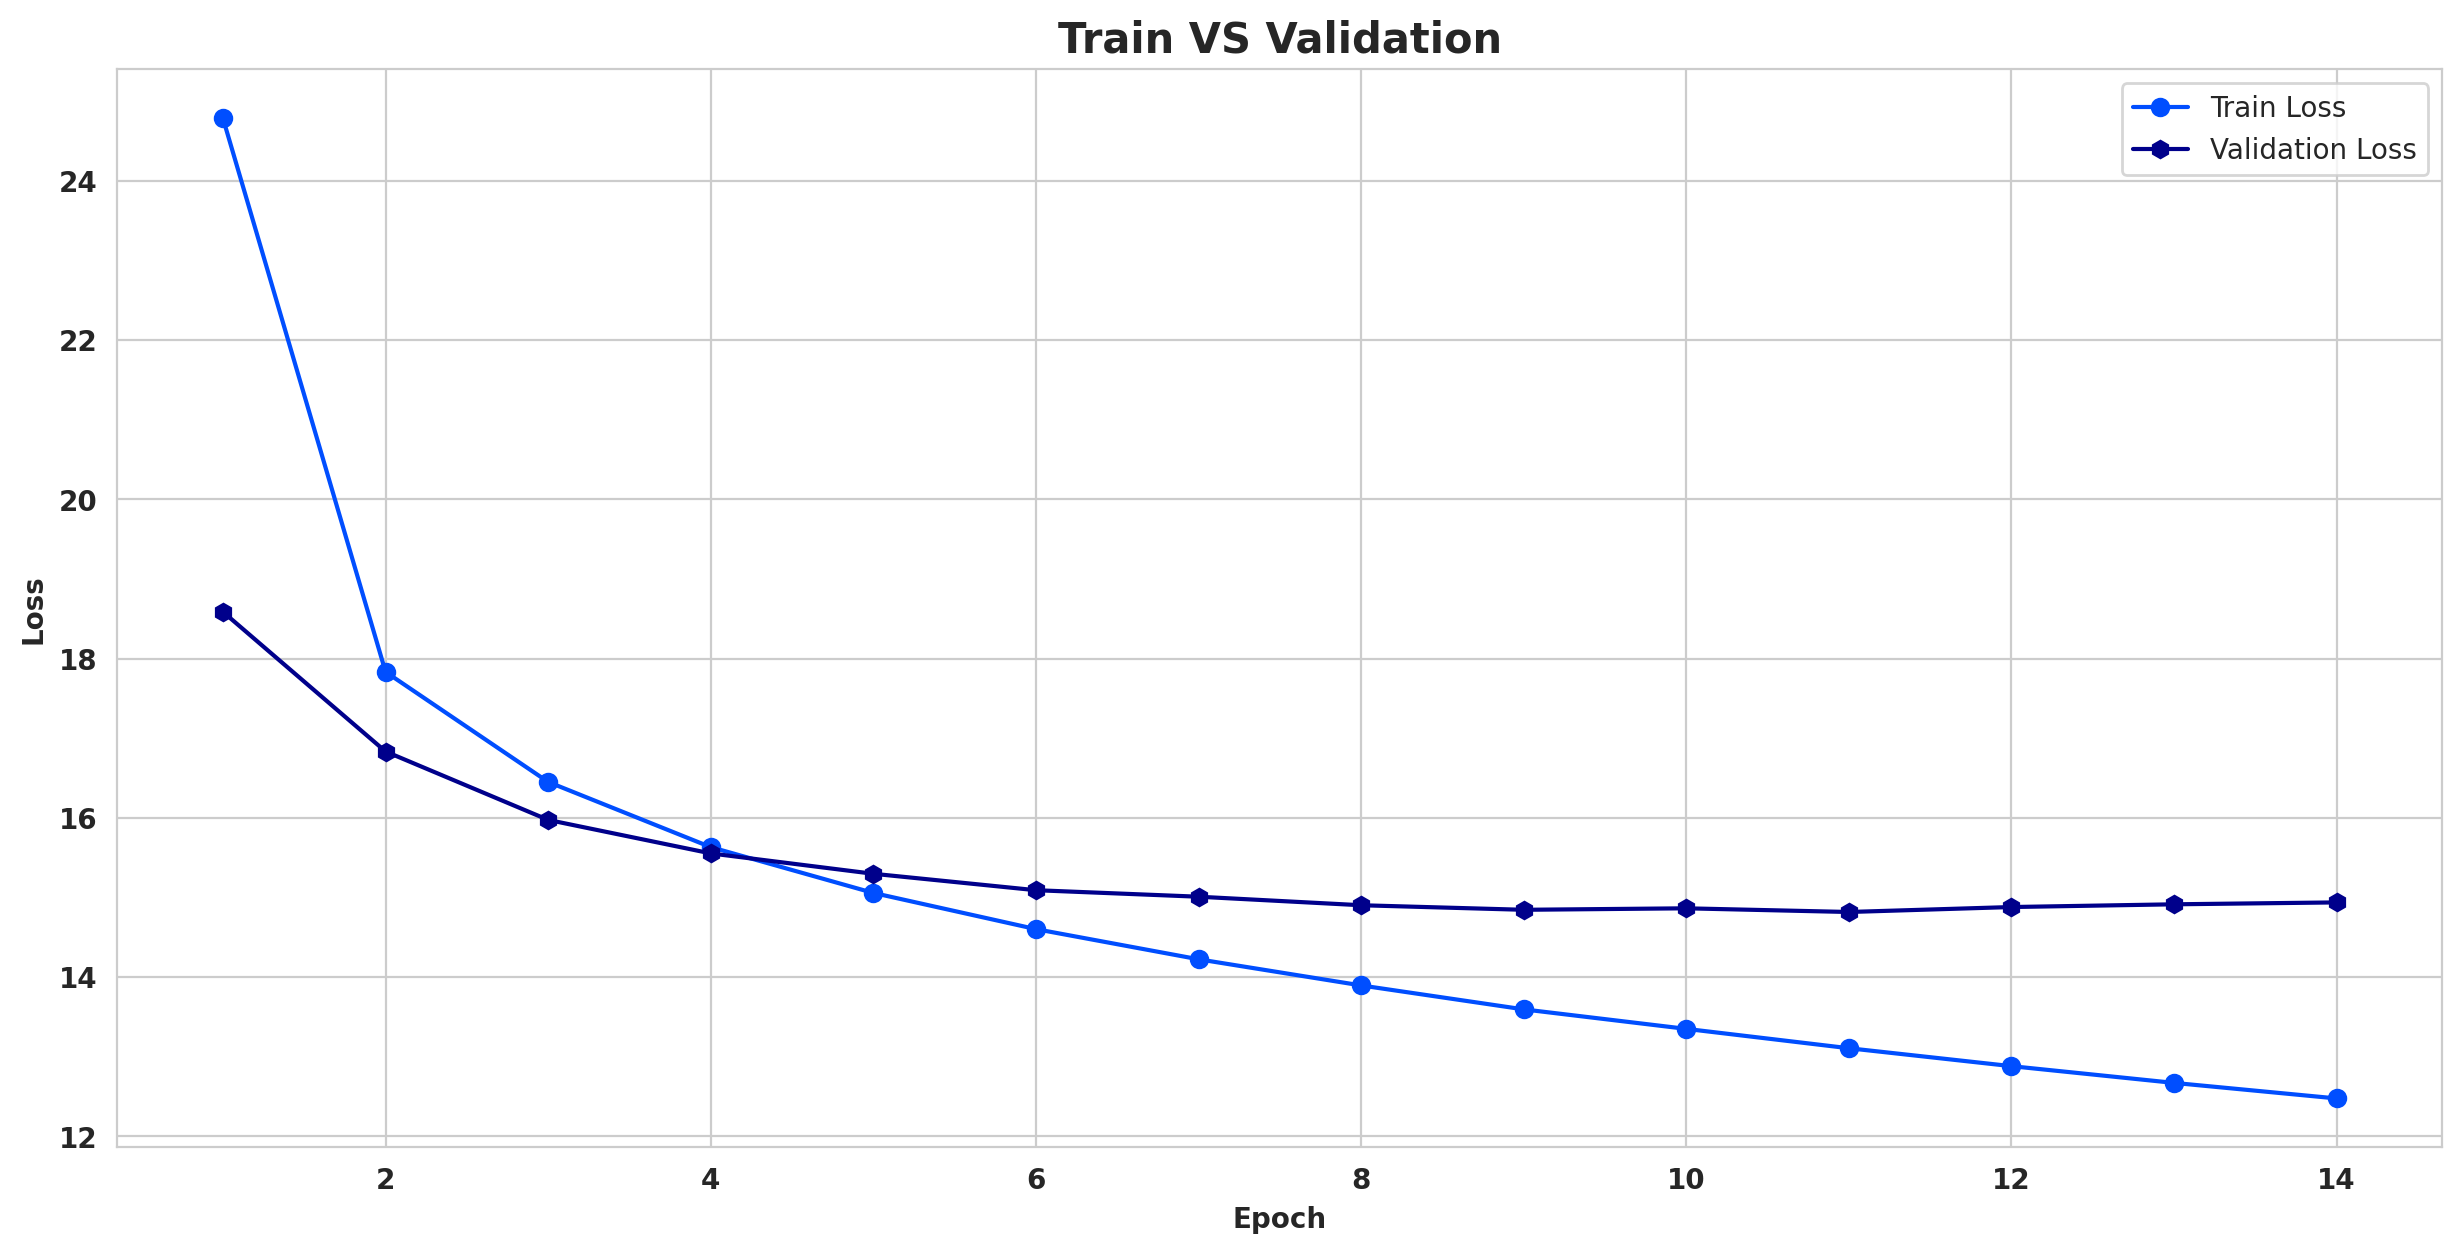

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#004EFF', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#00008B', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

# Inference
> ##### **Caption Generation:** At **each time step**, **the decoder takes** as input **the embedded image features** along with **the decoded captions** (starting with <start\> at the first time step), **predicting the probabilities** of **the next word**.
> ##### **Greedy algorithm:** To select  **the best caption**, **the greedy algorithm** is employed. This method, chooses **the most probable word** at each time step and **appends it** to the decoded captions **until** the selected word is the **<end\>** token, **or the length** of the decoded captions exceeds  **the maximum sequence length**.
> ##### **Evaluation** is performed using the **BLEU score**
> ##### **Visualization:** The function visualization() plots the **images along with their corresponding actual and predicted captions, accompanied by 4 BLEU scores**.

In [ ]:
vocab = vectorization.get_vocabulary()
INDEX_TO_WORD = {idx: word for idx, word in enumerate(vocab)}
MAX_DECODED_SENTENCE_LENGTH = SEQ_LENGTH - 1
test_images = list(test_data.keys())

def greedy_algorithm(image):
    # Read the image from the disk
    image = decode_and_resize(image)

    # Pass the image to the CNN
    image = tf.expand_dims(image, 0)
    image = caption_model.cnn_model(image)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(image, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(MAX_DECODED_SENTENCE_LENGTH):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(tokenized_caption, encoded_img, training=False, mask=mask)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = INDEX_TO_WORD[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    return decoded_caption

In [ ]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_data), position=0, leave=True, colour='green')
for image_id in test_data:
    cap = greedy_algorithm(image_id)
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()

  0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
# Metrics for Image Captioning: BLEU (1-4), METEOR, ROUGE-L, CIDEr and chrF
# Observations:
# - BLEU here is sentence-level and with smoothing (more stable for short captions).
# - For model validation, prefer also the aggregated evaluation (corpus-level) in the added cell below.
import math
import re
import numpy as np
from collections import Counter, defaultdict

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

try:
    from nltk.translate.meteor_score import meteor_score
except Exception:
    meteor_score = None


def _normalize_caption(s: str) -> str:
    s = s.replace('<start>', '').replace('<end>', '')
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s


def _tokenize(s: str):
    return _normalize_caption(s).split()


def bleu_sentence_scores(references, hypothesis: str):
    refs_tok = [_tokenize(r) for r in references]
    hyp_tok = _tokenize(hypothesis)

    # Recommended smoothing for short sentences
    smooth = SmoothingFunction().method4

    b1 = sentence_bleu(refs_tok, hyp_tok, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
    b2 = sentence_bleu(refs_tok, hyp_tok, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    b3 = sentence_bleu(refs_tok, hyp_tok, weights=(1 / 3, 1 / 3, 1 / 3, 0), smoothing_function=smooth)
    b4 = sentence_bleu(refs_tok, hyp_tok, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

    return {'bleu1': float(b1), 'bleu2': float(b2), 'bleu3': float(b3), 'bleu4': float(b4)}


def meteor(references, hypothesis: str):
    # NLTK (recent versions) expects *tokenized* inputs (Iterable[str])
    if meteor_score is None:
        return None

    refs_tok = [_tokenize(r) for r in references]
    hyp_tok = _tokenize(hypothesis)
    if not hyp_tok or not refs_tok:
        return 0.0

    try:
        return float(meteor_score(refs_tok, hyp_tok))
    except Exception:
        # Can fail if NLTK resources (ex.: wordnet) are not available
        return None


def _lcs_len(a_tokens, b_tokens):
    # DP O(n*m) - captions are short, so it's ok
    n, m = len(a_tokens), len(b_tokens)
    dp = [0] * (m + 1)
    for i in range(1, n + 1):
        prev = 0
        ai = a_tokens[i - 1]
        for j in range(1, m + 1):
            tmp = dp[j]
            if ai == b_tokens[j - 1]:
                dp[j] = prev + 1
            else:
                dp[j] = max(dp[j], dp[j - 1])
            prev = tmp
    return dp[m]


def rouge_l_f1(references, hypothesis: str):
    # ROUGE-L: takes the best F1 among the references
    hyp_t = _tokenize(hypothesis)
    if not hyp_t:
        return 0.0

    best = 0.0
    for r in references:
        ref_t = _tokenize(r)
        if not ref_t:
            continue
        lcs = _lcs_len(ref_t, hyp_t)
        prec = lcs / max(1, len(hyp_t))
        rec = lcs / max(1, len(ref_t))
        if prec + rec == 0:
            f1 = 0.0
        else:
            f1 = (2 * prec * rec) / (prec + rec)
        best = max(best, f1)
    return float(best)


def _ngrams(tokens, n):
    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]


def chrf(references, hypothesis: str, n: int = 6, beta: float = 2.0):
    # chrF (character n-gram F-score). Useful as an extra metric without external dependencies.
    hyp = _normalize_caption(hypothesis)
    if not hyp:
        return 0.0

    def char_ngrams(s, k):
        s = s.replace(' ', '')
        return [s[i:i + k] for i in range(len(s) - k + 1)]

    best_f = 0.0
    for ref in references:
        ref = _normalize_caption(ref)
        if not ref:
            continue

        p_sum = 0.0
        r_sum = 0.0
        count = 0
        for k in range(1, n + 1):
            hyp_ngr = Counter(char_ngrams(hyp, k))
            ref_ngr = Counter(char_ngrams(ref, k))
            if not hyp_ngr or not ref_ngr:
                continue

            overlap = sum((hyp_ngr & ref_ngr).values())
            p = overlap / max(1, sum(hyp_ngr.values()))
            r = overlap / max(1, sum(ref_ngr.values()))
            p_sum += p
            r_sum += r
            count += 1

        if count == 0:
            continue

        p_avg = p_sum / count
        r_avg = r_sum / count
        if p_avg + r_avg == 0:
            f = 0.0
        else:
            f = (1 + beta**2) * p_avg * r_avg / (beta**2 * p_avg + r_avg)
        best_f = max(best_f, f)

    return float(best_f)


class CiderScorer:
    """Light implementation of CIDEr (COCO approximation), without external dependencies."""

    def __init__(self, n: int = 4, sigma: float = 6.0):
        self.n = n
        self.sigma = sigma
        self.idf = None
        self.N = 0

    def fit(self, all_references):
        # all_references: List[List[str]]  (by image: list of references)
        df = defaultdict(int)
        self.N = len(all_references)

        for refs in all_references:
            seen = set()
            for r in refs:
                toks = _tokenize(r)
                for k in range(1, self.n + 1):
                    for ng in set(_ngrams(toks, k)):
                        seen.add((k, ng))
            for key in seen:
                df[key] += 1

        # Smooth IDF
        self.idf = {key: math.log((self.N + 1.0) / (dfv + 1.0)) for key, dfv in df.items()}
        return self

    def _tfidf_vec(self, sentence: str, n: int):
        toks = _tokenize(sentence)
        ng = _ngrams(toks, n)
        if not ng:
            return {}, 0.0
        tf = Counter(ng)

        norm = 0.0
        vec = {}
        for g, c in tf.items():
            key = (n, g)
            w = (c / len(ng)) * self.idf.get(key, 0.0)
            vec[key] = w
            norm += w * w
        return vec, math.sqrt(norm)

    def _cosine(self, v1, n1, v2, n2):
        if n1 == 0.0 or n2 == 0.0:
            return 0.0
        dot = 0.0
        if len(v1) > len(v2):
            v1, v2 = v2, v1
        for k, w in v1.items():
            dot += w * v2.get(k, 0.0)
        return dot / (n1 * n2)

    def score(self, references, hypothesis: str):
        if self.idf is None:
            raise ValueError('CiderScorer needs fit() before score().')

        hyp_len = len(_tokenize(hypothesis))
        ref_lens = [len(_tokenize(r)) for r in references]
        ref_len = float(np.mean(ref_lens)) if ref_lens else 0.0
        length_pen = math.exp(-((hyp_len - ref_len) ** 2) / (2 * (self.sigma ** 2))) if (hyp_len and ref_len) else 0.0

        scores_n = []
        for n in range(1, self.n + 1):
            v_h, nh = self._tfidf_vec(hypothesis, n)
            sims = []
            for r in references:
                v_r, nr = self._tfidf_vec(r, n)
                sims.append(self._cosine(v_h, nh, v_r, nr))
            scores_n.append(float(np.mean(sims)) if sims else 0.0)

        return float(10.0 * length_pen * sum(scores_n) / self.n)


def build_default_cider_scorer(data_dict):
    # data_dict: {img_path: [ref1, ref2, ...]}
    all_refs = []
    for k in data_dict:
        refs = data_dict[k]
        refs = [x.replace('<start> ', '').replace(' <end>', '') for x in refs]
        all_refs.append(refs)
    return CiderScorer().fit(all_refs)


# =====================
# CLIPScore (state-of-the-art for image-text alignment)
# =====================

_CLIP_WARNED = False

class ClipScorer:
    def __init__(self, model_name: str = 'ViT-B-32', pretrained: str = 'openai', device=None, hf_model_id: str = 'openai/clip-vit-base-patch32'):
        self.model_name = model_name
        self.pretrained = pretrained
        self.hf_model_id = hf_model_id
        self.device = device
        self._loaded = False

    def _load(self):
        """Tries to load CLIP via open_clip; if not, tries via transformers."""
        global _CLIP_WARNED
        if self._loaded:
            return

        # 1) torch is always required
        try:
            import torch
        except Exception as e:
            if not _CLIP_WARNED:
                print(f"CLIPScore unavailable (requires torch): {e}")
                _CLIP_WARNED = True
            self._backend = None
            self._loaded = True
            return

        device = self.device
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # 2) try open_clip (lighter when installed)
        try:
            import open_clip
            from PIL import Image

            model, preprocess, tokenizer = open_clip.create_model_and_transforms(self.model_name, pretrained=self.pretrained)
            model = model.eval().to(device)

            self._torch = torch
            self._Image = Image
            self._model = model
            self._preprocess = preprocess
            self._tokenizer = tokenizer
            self._device = device
            self._backend = 'open_clip'
            self._loaded = True
            return
        except Exception:
            pass

        # 3) fallback: transformers (requires transformers + Pillow; may download weights on first run)
        try:
            from PIL import Image
            from transformers import CLIPModel, CLIPProcessor

            model = CLIPModel.from_pretrained(self.hf_model_id)
            processor = CLIPProcessor.from_pretrained(self.hf_model_id)
            model = model.eval().to(device)

            self._torch = torch
            self._Image = Image
            self._model = model
            self._processor = processor
            self._device = device
            self._backend = 'transformers'
            self._loaded = True
            return
        except Exception as e:
            if not _CLIP_WARNED:
                print(
                    "CLIPScore unavailable: install `open_clip_torch` or `transformers` + `torch` + `Pillow`. "
                    f"Error: {e}"
                )
                _CLIP_WARNED = True
            self._backend = None
            self._loaded = True

    def score(self, image_path: str, caption: str):
        """CLIPScore = 2.5 * max(0, cosine(img, text))."""
        self._load()
        if self._backend is None:
            return None

        torch = self._torch
        cap = _normalize_caption(caption)
        if not cap:
            return 0.0

        try:
            img = self._Image.open(image_path).convert('RGB')
        except Exception:
            return None

        with torch.no_grad():
            if self._backend == 'open_clip':
                image = self._preprocess(img).unsqueeze(0).to(self._device)
                text = self._tokenizer([cap]).to(self._device)

                img_feat = self._model.encode_image(image)
                txt_feat = self._model.encode_text(text)
            else:
                inputs = self._processor(text=[cap], images=[img], return_tensors='pt', padding=True)
                inputs = {k: v.to(self._device) for k, v in inputs.items()}

                img_feat = self._model.get_image_features(**inputs)
                txt_feat = self._model.get_text_features(**inputs)

            img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
            txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
            cos = (img_feat * txt_feat).sum(dim=-1).item()

        return float(2.5 * max(0.0, cos))


# Global instance (model cache). Adjust model_name/pretrained if you want.
clip_scorer = ClipScorer(model_name='ViT-B-32', pretrained='openai')


# BERTScore (semantic) - optional
# - Requires package `bert-score` and typically downloads model weights (needs internet on first run).
# - So we leave it as an optional function to run when the environment allows.

def bertscore_best_f1(references, hypothesis: str, lang: str = 'en', model_type=None):
    try:
        from bert_score import score as bert_score
    except Exception:
        return None

    refs = [_normalize_caption(r) for r in references]
    hyp = _normalize_caption(hypothesis)
    if not hyp or not refs:
        return 0.0

    cands = [hyp] * len(refs)
    P, R, F = bert_score(cands, refs, lang=lang, model_type=model_type, verbose=False)
    return float(F.max().item())


def caption_metrics_lines(actual, predicted_caption: str, cider_scorer: CiderScorer = None, image_path=None):
    bleu = bleu_sentence_scores(actual, predicted_caption)
    met = meteor(actual, predicted_caption)
    rL = rouge_l_f1(actual, predicted_caption)
    cf = chrf(actual, predicted_caption)

    lines = [
        f"BLEU-4: {bleu['bleu4']:.5f}",
        f"BLEU-3: {bleu['bleu3']:.5f}",
        f"BLEU-2: {bleu['bleu2']:.5f}",
        f"BLEU-1: {bleu['bleu1']:.5f}",
    ]

    if met is not None:
        lines.append(f"METEOR: {met:.5f}")
    else:
        lines.append('METEOR: (unavailable - may require NLTK resources)')

    lines.append(f"ROUGE-L: {rL:.5f}")
    lines.append(f"chrF: {cf:.5f}")

    # CLIPScore (if image_path is provided and dependencies are installed)
    if image_path is not None:
        cs = clip_scorer.score(image_path, predicted_caption)
        if cs is not None:
            lines.append(f"CLIPScore: {cs:.5f}")
        else:
            lines.append('CLIPScore: (unavailable - requires torch + open_clip/transformers + Pillow)')
    else:
        lines.append('CLIPScore: (pass image_path to calculate)')

    # BERTScore (semantic) - optional
    bs = bertscore_best_f1(actual, predicted_caption, lang='en')
    if bs is not None:
        lines.append(f"BERTScore-F1: {bs:.5f}")
    else:
        lines.append('BERTScore-F1: (unavailable - requires bert-score)')

    if cider_scorer is not None:
        try:
            c = cider_scorer.score(actual, predicted_caption)
            lines.append(f"CIDEr: {c:.5f}")
        except Exception as e:
            lines.append(f"CIDEr: (error calculating: {e})")
    else:
        lines.append('CIDEr: (initialize with build_default_cider_scorer(test_data))')

    lines.append(f"Generated Caption: {predicted_caption}")
    return lines


# Keeps compatibility with the previous signature used in the notebook (old visualization)
def BLEU_score(actual, predicted):
    return caption_metrics_lines(actual, predicted[0], cider_scorer=None)


### Visualizing some of the **test images** along with their corresponding **generated captions**

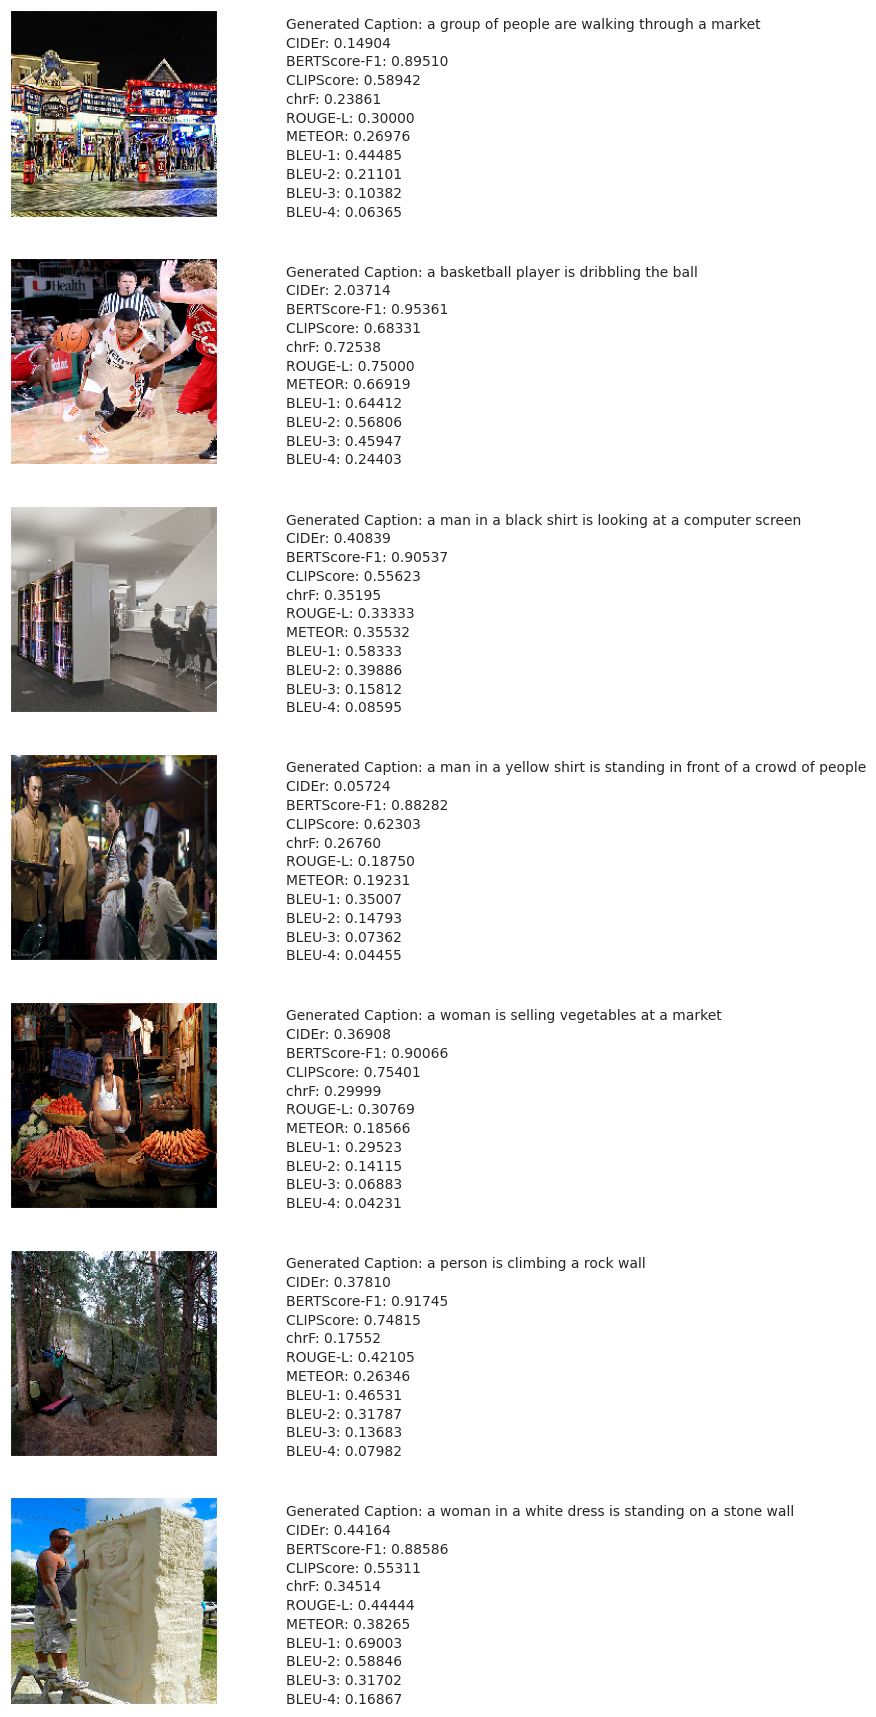

In [ ]:
def visualization(data, generated_captions, evaluator, num_of_images):
    keys = list(data.keys())  # List of all test images
    images = [np.random.choice(keys) for _ in range(num_of_images)]  # Randomly selected images

    count = 1
    fig = plt.figure(figsize=(7, 22))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace('<start> ', '') for x in actual_cap]
        actual_cap = [x.replace(' <end>', '') for x in actual_cap]

        caption = generated_captions[filename]
        caps_with_score = evaluator(actual_cap, caption, filename)

        image_load = load_img(filename, target_size=(199, 199, 3))
        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0, i, text, fontsize=10)
        count += 1
    plt.show()


# CIDEr needs IDF in the reference corpus; we initialize once and reuse
cider_scorer = build_default_cider_scorer(test_data)

def evaluator_all_metrics(actual_caps, predicted_caption, image_path=None):
    return caption_metrics_lines(
        actual_caps,
        predicted_caption,
        cider_scorer=cider_scorer,
        image_path=image_path,
    )

visualization(test_data, generated_captions, evaluator_all_metrics, 7)

In [ ]:
# Aggregated evaluation (corpus-level) on the test set
# Tip: BLEU corpus-level is more appropriate for reporting model results than average sentence-level.
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

def compute_corpus_metrics(data, generated, cider_scorer=None, max_items=None):
    keys = [k for k in generated.keys() if k in data]
    if max_items is not None:
        keys = keys[:max_items]

    refs_corpus = []  # List[List[List[str]]]
    hyps = []         # List[List[str]]

    meteor_list = []
    rouge_list = []
    chrf_list = []
    cider_list = []
    clip_list = []
    bert_list = []

    for k in keys:
        refs = [x.replace('<start> ', '').replace(' <end>', '') for x in data[k]]
        hyp = generated[k]

        refs_corpus.append([_tokenize(r) for r in refs])
        hyps.append(_tokenize(hyp))

        m = meteor(refs, hyp)
        if m is not None:
            meteor_list.append(m)

        rouge_list.append(rouge_l_f1(refs, hyp))
        chrf_list.append(chrf(refs, hyp))

        # CLIPScore (se disponível)
        cs = clip_scorer.score(k, hyp)
        if cs is not None:
            clip_list.append(cs)

        # BERTScore (se disponível)
        bs = bertscore_best_f1(refs, hyp, lang='en')
        if bs is not None:
            bert_list.append(bs)

        if cider_scorer is not None:
            cider_list.append(cider_scorer.score(refs, hyp))

    smooth = SmoothingFunction().method4

    bleu1 = corpus_bleu(refs_corpus, hyps, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
    bleu2 = corpus_bleu(refs_corpus, hyps, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    bleu3 = corpus_bleu(refs_corpus, hyps, weights=(1 / 3, 1 / 3, 1 / 3, 0), smoothing_function=smooth)
    bleu4 = corpus_bleu(refs_corpus, hyps, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

    out = {
        'BLEU-1 (corpus)': float(bleu1),
        'BLEU-2 (corpus)': float(bleu2),
        'BLEU-3 (corpus)': float(bleu3),
        'BLEU-4 (corpus)': float(bleu4),
        'ROUGE-L (média)': float(np.mean(rouge_list)) if rouge_list else 0.0,
        'chrF (média)': float(np.mean(chrf_list)) if chrf_list else 0.0,
        'METEOR (média)': float(np.mean(meteor_list)) if meteor_list else None,
        'CLIPScore (média)': float(np.mean(clip_list)) if clip_list else None,
        'BERTScore-F1 (média)': float(np.mean(bert_list)) if bert_list else None,
        'CIDEr (média)': float(np.mean(cider_list)) if cider_list else None,
        'N imagens': len(keys),
    }
    return out


scores = compute_corpus_metrics(test_data, generated_captions, cider_scorer=cider_scorer)
for k, v in scores.items():
    if v is None:
        print(f'{k}: (unavailable)')
    elif isinstance(v, float):
        print(f'{k}: {v:.6f}')
    else:
        print(f'{k}: {v}')
# Optional extra metric (semantic): BERTScore
# - Requires package `bert-score` and typically downloads model weights (needs internet on first run).
# - So we leave it as an optional function to run when the environment allows.

def bertscore_best_f1(references, hypothesis: str, lang: str = 'en', model_type=None):
    try:
        from bert_score import score as bert_score
    except Exception:
        return None

    refs = [_normalize_caption(r) for r in references]
    hyp = _normalize_caption(hypothesis)
    if not hyp or not refs:
        return 0.0

    cands = [hyp] * len(refs)
    P, R, F = bert_score(cands, refs, lang=lang, model_type=model_type, verbose=False)
    return float(F.max().item())


BLEU-1 (corpus): 0.584824
BLEU-2 (corpus): 0.399747
BLEU-3 (corpus): 0.264779
BLEU-4 (corpus): 0.176634
ROUGE-L (média): 0.399944
chrF (média): 0.328094
METEOR (média): 0.348891
CLIPScore (média): 0.661015
BERTScore-F1 (média): 0.912583
CIDEr (média): 0.575892
N imagens: 105


In [ ]:
import urllib.request
import tempfile
import os

IMAGE_URL = 'https://imgs.search.brave.com/kWtLzGCusm1oCrmmD1J_EvYoWJJi4NXL51QxRrZDo3A/rs:fit:500:0:1:0/g:ce/aHR0cHM6Ly9pbWcu/ZnJlZXBpay5jb20v/Zm90b3MtZ3JhdGlz/L3Byb3RlY2FvLWRl/LW1hc2NhcmEtZmFj/aWFsLW5hLXZpZGEt/ZGlhcmlhXzIzLTIx/NDkwOTY4MTAuanBn/P3NlbXQ9YWlzX2h5/YnJpZCZ3PTc0MCZx/PTgw'

def generate_caption_from_url(url):
    # Create a request with a User-Agent header
    # This helps bypass some server restrictions that block automated requests
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    req = urllib.request.Request(url, headers=headers)

    # Download the image to a temporary file
    try:
        with urllib.request.urlopen(req) as response:
            # Determine file extension from URL if possible, default to .jpg
            file_extension = os.path.splitext(url.split('/')[-1].split('?')[0])[-1] or '.jpg'
            with tempfile.NamedTemporaryFile(delete=False, suffix=file_extension) as tmp_file:
                tmp_file.write(response.read())
                image_path = tmp_file.name
    except Exception as e:
        print(f"Error downloading image from URL: {e}")
        return None # Return None if download fails

    # Generate caption using the greedy algorithm
    caption = greedy_algorithm(image_path)

    # Clean up the temporary file
    os.remove(image_path)

    return caption

In [ ]:
predicted_caption = generate_caption_from_url(IMAGE_URL)
print(f"Generated Caption for URL: {predicted_caption}")

Generated Caption for URL: a man in a suit is walking down the street


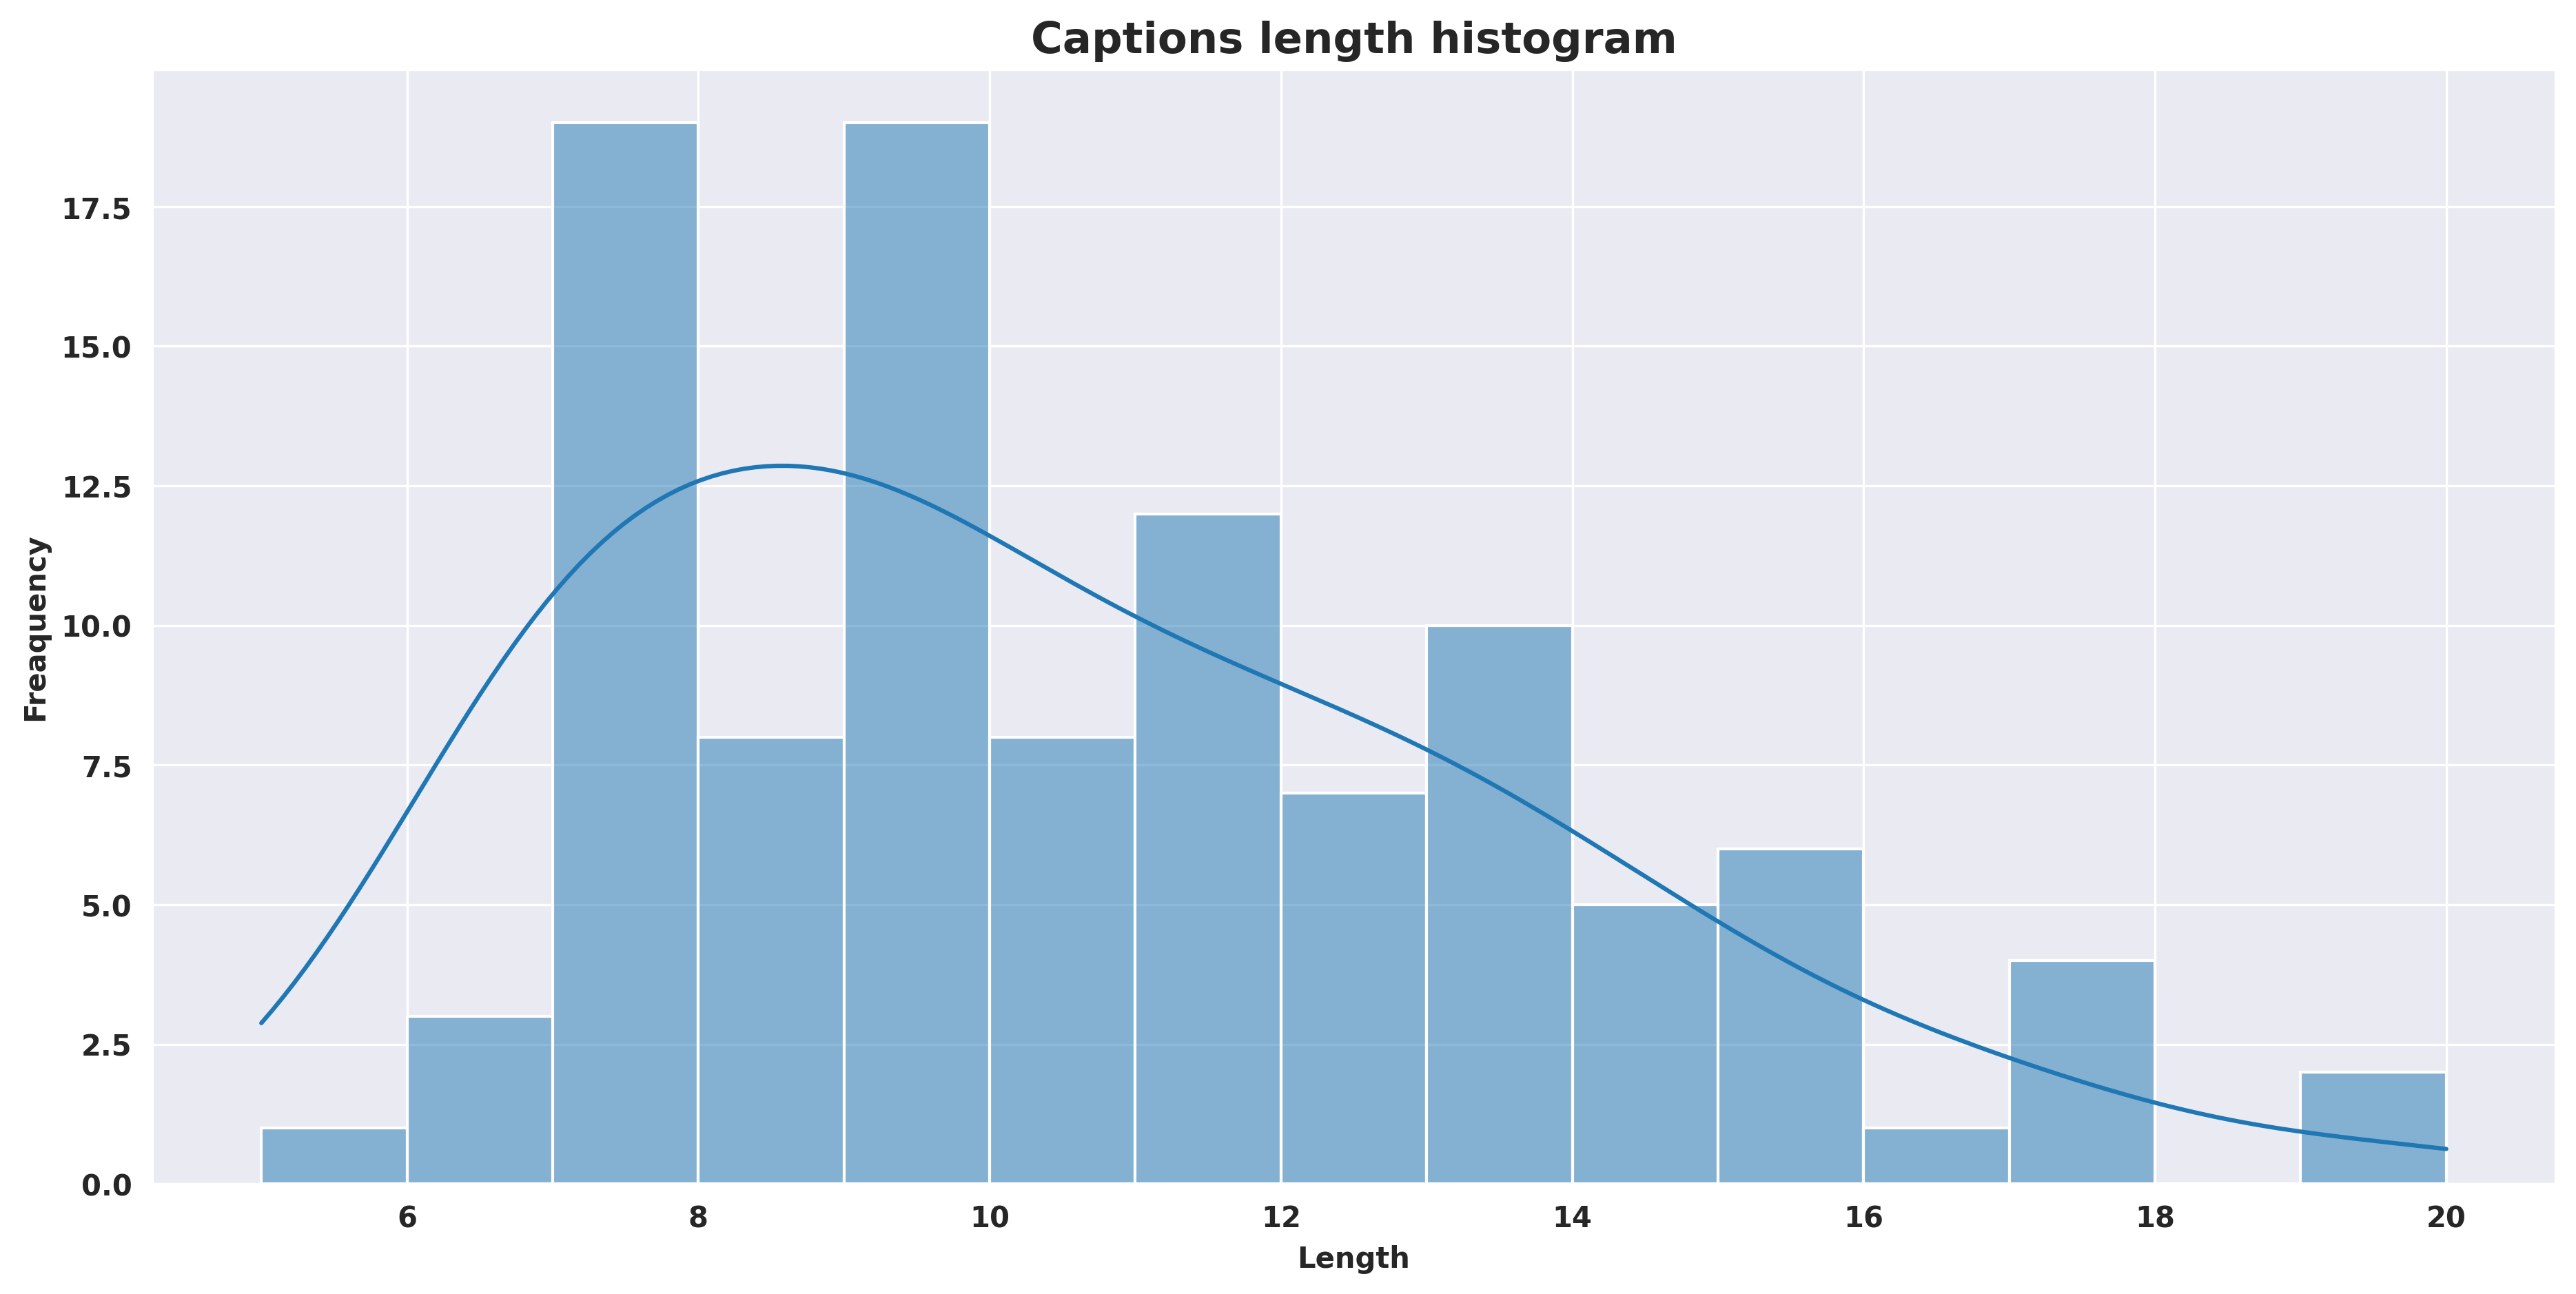

In [ ]:
captions_length(list(generated_captions.values()))

In [ ]:
word_occurrences(list(generated_captions.values()))

### Parallel analyses, conducted using a **smaller dataset**, have yielded almost similar results.
> #### For further insights, please refer to the following links.
> #### LSTMs for Flickr8k: https://www.kaggle.com/code/saeedghamshadzai/image-captioning-lstm-cnn
> #### Transformers for Flickr8k: https://www.kaggle.com/code/saeedghamshadzai/image-captioning-transformers-flickr8k

## I hope you found it both **enjoyable** and **informative**. **Please consider upvoting, sharing**, and **trying out** the concepts presented. **Feel free to share your thoughts, questions, or suggestions** in the **comment section** below. **Happy coding!**

# **Thanks For Attention!**